In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline     
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
from sklearn.datasets import make_blobs
from bico.core import BICO
from bico.geometry.point import Point 
np.random.seed(123)

In [2]:
bank_data = pd.read_csv('uci_census.csv')
bank_data 


bank_data.loc[bank_data['gender'] == 'Male', 'gender'] = 1
bank_data.loc[bank_data['gender'] == 'Female', 'gender'] = 0


bank_data_married = bank_data[bank_data['gender'] == 1][['gender','age', 'fnlwgt', 'education_num', 'capital_gain', 'hours_per_week']]
bank_data_single = bank_data[bank_data['gender'] == 0][['gender','age', 'fnlwgt', 'education_num', 'capital_gain', 'hours_per_week']]


bank_data_married

,gender,age,fnlwgt,education_num,capital_gain,hours_per_week
0,1,39,77516,13,2174,40
1,1,50,83311,13,0,13
2,1,38,215646,9,0,40
3,1,53,234721,7,0,40
7,1,52,209642,9,0,45
...,...,...,...,...,...,...
48836,1,33,245211,13,0,40
48838,1,64,321403,9,0,40
48839,1,38,374983,13,0,50
48840,1,44,83891,13,5455,40


In [3]:

# rnge= 300
# bank_red= bank_data_married[:3000]
# bank_red= bank_red.reset_index()
# bank_red=bank_red.drop('index' , axis=1)

# bank_blue=bank_data_single[:3000]
# bank_blue=bank_blue.reset_index()
# bank_blue=bank_blue.drop('index' , axis=1)

# bank_full_data= bank_red.append(bank_blue)
# bank_full_data=bank_full_data.reset_index()
# bank_full_data=bank_full_data.drop('index' , axis=1)

# print("Married(Red)")
# print(bank_red.head())
# print("Single(Blue)")
# print(bank_blue.head())

# bank_full_data.iloc[:,1:]

In [4]:
def distance(a, b, order=2):
    return np.linalg.norm(x=np.array(a)-np.array(b), ord=order)


def balance_calculation( data , centers, mapping):
    

    fair = dict([(i, [0, 0]) for i in centers])
    for i in mapping:
        fair[i[1]][1] += 1
        if data[i[0]][0] == 1: 
            fair[i[1]][0] += 1

    curr_b = []
    for i in list(fair.keys()):
        p = fair[i][0]
        q = fair[i][1] - fair[i][0]
        if p == 0 or q == 0:
            balance = 0
        else:
            balance = min(float(p/q), float(q/p))
        curr_b.append(balance)
        
    print(curr_b)

    return min(curr_b)

In [5]:
# A = (1, 2, 3)
# B = (4, 6, 8)

# d_squared = squared_distance(A, B)
# print(d_squared)

In [6]:
def plot_analysis(degrees, costs, balances, step_size):
    fig, ax1 = plt.subplots(figsize=(10,6))

    # plot costs
    ax1.plot(degrees, costs, marker='.', color='blue')
    ax1.set_xlabel('Degrees')
    ax1.set_ylabel('Costs', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(list(range(min(degrees), max(degrees) + 1, step_size)))
    ax1.grid(True)

    # create twin axis
    ax2 = ax1.twinx()

    # plot balances
    ax2.plot(degrees, balances, marker='x', color='saddlebrown')
    ax2.set_ylabel('Balance', color='saddlebrown')
    ax2.tick_params(axis='y', labelcolor='saddlebrown')
    
    plt.title('Analysis of Degrees, Costs, and Balances', fontsize=14)
    plt.show()


In [7]:
cost_matrx = np.array([
    [1, 2, 4, 100],
    [2, 1, 2, 100],
    [4, 2, 1, 2],
    [2, 100, 100, 4]
])

row_indices, col_indices = linear_sum_assignment(cost_matrx)   #hungarian algo n work to n worker with cost matrix

matching = list(zip(row_indices, col_indices))
sum_cost=0
#print("matching" , matching)
for i, j in matching:
    print(f"{i}-{j}: {cost_matrx[i][j]}")
    sum_cost += cost_matrx[i][j]
print("Cost of the : ", sum_cost) 

0-0: 1
1-1: 1
2-2: 1
3-3: 4
Cost of the :  7


In [8]:
def make_cost_matrix(bank_red, bank_blue):
    num_red = len(bank_red)
    num_blue = len(bank_blue)
    cost_matrix = np.zeros((num_red, num_blue))

    for i in range(num_red):
        for j in range(num_blue):
            cost_matrix[i][j] = distance(bank_red[i],bank_blue[j],2)
    return cost_matrix


In [9]:
#algo1
#takes red and blue data 
#output  matching between red and blue , Fairlet_repre which is the mean of red and blue. 


def compute_fairlet_decomposition(bank_red, bank_blue):
    """
    Computes the fairlet decomposition of two sets of points.
    """
    size= len(bank_red)
    F = []
    cost_matrx=make_cost_matrix(bank_red, bank_blue)
    row_indices, col_indices = linear_sum_assignment(cost_matrx)  # Hungarian algorithm
    matching = list(zip(row_indices, col_indices))
    for r, b in matching:
        F.append((np.array(bank_red[r]) + np.array(bank_blue[b])) / 2)
        
    print("FD done")
    return np.array(F) , matching



In [10]:
# Fairlets, matching= compute_fairlet_decomposition(bank_red.iloc[:,1:].values.tolist(),bank_blue.iloc[:,1:].values.tolist())
# # for i, j in matching:
# #     print(f"{i}-{j}: {cost_matrix[i][j]}")

In [11]:
#computes kmeans++ 
# input - takes input data and no. of cluster
#returns - centroids (intial) , cost of clustering with the input , mapping between the X and index of the center. 

def kmeans_pp(X, K):
    # Choose the first centroid randomly from the data points
    centroids = [X[np.random.choice(len(X))]]

    # Choose the remaining K-1 centroids using K-means++ algorithm
    for i in range(1, K):
        # Compute the distances of each point to the closest centroid
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in X])
        
        # Compute the probabilities of choosing each point as the next centroid
        probs = distances / np.sum(distances)
        
        # Choose the next centroid randomly based on the computed probabilities
        next_centroid = X[np.random.choice(len(X), p=probs)]
        
        # Add the next centroid to the list of centroids
        centroids.append(next_centroid)

    # Assign each point to the closest centroid
#     mapping = np.array([np.argmin([np.linalg.norm(x-c)**2 for c in centroids]) for x in X])
    
#     # Compute the cost of the clustering
#     cost = np.sum([np.linalg.norm(X[i]-centroids[mapping[i]])**2 for i in range(len(X))])
    print("kmeasnpp done")
    return centroids #, cost, mapping


# Generate sample data for testing the algorithm
# X, y = make_blobs(n_samples=500, centers=5, random_state=42)

# # Choose the number of clusters
# K = 5

# # Choose the initial centroids using K-means++ algorithm


# # Print the initial centroids
# print("Initial centroids:", kmeans_pp(X,K))


In [12]:
#algo 2 CKLV-kmeans ++ 
# compute fairlet_representatives , and then apply kmeans++ on the fairlet_repres and then mapping 
#                                                          the farilets points to the same center
#input - red and blue data 
# output - centroid using kmeans , mapping of the original X


def CKLV_kmeans(bank_red, bank_blue,k):
    Fair_repr , matching_fairlet = compute_fairlet_decomposition(bank_red, bank_blue)
    initial_centroids  = kmeans_pp(Fair_repr, k)
#     initial_centroids , cost , mapping_fairlets_rep_to_C = kmeans_pp(Fair_repr, k)
    mapping_X = [0]*len(bank_red+ bank_blue)
#     i=0;
#     for r, b in matching_fairlet:
#         mapping_X[r]= mapping_fairlets_rep_to_C[i]
#         mapping_X[b]= mapping_fairlets_rep_to_C[i]
#         i=i+1
 
    return initial_centroids,mapping_X 



In [13]:
#CKLV_kmeans(bank_red.iloc[:,1:].values.tolist(), bank_blue.iloc[:,1:].values.tolist(),5)

In [14]:
#algo - 3 
#input - red and blue points and centers gained through CKLV_kmeans
#output - mapping of Original X. as well the input centers as well.


def fair_assign(bank_red, bank_blue, centers):
    # Initialize cost matrix and mapping dictionary
    num_red = len(bank_red)
    num_blue = len(bank_blue)
    cost_matrix = np.zeros((num_red, num_blue))

    # Compute cost matrix and mapping dictionary
    for i in range(num_red):
        for j in range(num_blue):
            cost_matrix[i][j] = min([distance(bank_red[i],center,2) + distance(bank_blue[j],center,2)for center in centers])
    print("cost matrix done")
    # Compute min cost perfect matching wrt cost matrix
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    matching_fa = list(zip(row_indices, col_indices))
    
    fair_mapping_X = [0]*len(bank_red + bank_blue)
    i=0;
    # Assign points to centers based on matching
    for r, b in matching_fa:
        center_distances = [distance(bank_red[r],center,2) + distance(bank_blue[b],center,2) for center in centers]
        center_index = center_distances.index(min(center_distances))
#         print(f"{r}-{b}: {center_index}")
        fair_mapping_X[r]= center_index
        fair_mapping_X[b]= center_index
        i=i+1

    return fair_mapping_X,centers



def reassigned_CKVL(bank_red, bank_blue,k):
    initial_centroids ,mapping_X = CKLV_kmeans(bank_red,bank_blue,k)
    fair_mapping_X, initial_centroids = fair_assign(bank_red, bank_blue, initial_centroids)
    #print(fair_mapping_X, initial_centroids) 

In [15]:
#reassigned_CKVL(bank_red.iloc[:,1:].values.tolist(), bank_blue.iloc[:,1:].values.tolist(),5)

In [16]:
def update_centers(X, mapping_X, k):
    """
    Update the centers based on the mapping of points to the centers.
    """
    centers = np.zeros((k, 5))
    counts = np.zeros(k)
    for i in range(len(X)):
        center_idx = mapping_X[i]
        centers[center_idx] += X[i]
        counts[center_idx] += 1
    for j in range(k):
        if counts[j] > 0:
            centers[j] /= counts[j]
    return centers


def fair_kmeans_pp(bank_red, bank_blue, k):
    initial_centroids, mapping_X = CKLV_kmeans(bank_red, bank_blue,k)
    fair_mapping_X, centers = fair_assign(bank_red, bank_blue, initial_centroids)
    return  fair_mapping_X , centers
    
    
#     centers = initial_centroids
# #     print(centers)
    
#     cost=0
#     for i in range(1,2):
#         fair_mapping_X, prev_centers = fair_assign(bank_red, bank_blue, centers)
#         cost = calculate_kmeans_cost(bank_red + bank_blue , prev_centers , fair_mapping_X )
#         #centers = update_centers(bank_red + bank_blue, fair_mapping_X, k)
#         #print(fair_mapping_X , prev_centers)
# #         print("ndz")
# #         print(cost)
#     return cost


def fair_kmeans_pp_cs(bank_red_cs, bank_blue_cs, k,bank_red,bank_blue):
    initial_centroids, mapping_X = CKLV_kmeans(bank_red_cs, bank_blue_cs,k)
    fair_mapping_X, centers = fair_assign(bank_red_cs, bank_blue_cs, initial_centroids)
    return centers
    
    
#     centers = initial_centroids
#     #costx = calculate_kmeans_cost(bank_red_cs + bank_blue_cs ,centers , mapping_X )
#     #print(centers)
    
#     cost=0
#     for i in range(1,2):
#         fair_mapping_X, prev_centers = fair_assign(bank_red, bank_blue, centers)
#         cost = calculate_kmeans_cost(bank_red + bank_blue , prev_centers , fair_mapping_X )
#         centers = update_centers(bank_red + bank_blue, fair_mapping_X, k)
#         #print(fair_mapping_X , prev_centers)
# #         print("ndz")
# #         print(cost)
#     return cost
        


In [17]:

def calculate_kmeans_cost(data, centers, mapping):
    total_cost = 0
    for i in range(len(data)):
        assigned_center = mapping[i]
        center_coords = centers[assigned_center]
        dist = np.linalg.norm(np.array(data[i]) - np.array(center_coords))
        total_cost += dist
    return total_cost

# import numpy as np

# def kmeans_cost(data, centers):
#     k = len(centers)
#     distances = np.zeros((len(data), k))
#     for i in range(k):
#         distances[:, i] = np.linalg.norm(data - centers[i], axis=1)
#     assignments = np.argmin(distances, axis=1)
#     cost = np.sum(np.min(distances, axis=1))
#     return cost

In [18]:
projections = 5
def run_bico(X,size):
    bico = BICO(5, projections, size)
    
    for row in X:
        bico.insert_point(Point(row))
        
    c = bico.get_coreset()
    
    X_tile= []

    for row in c:
        ar = np.tile(row[1:], (int(row[0]),1))   # creates new instance of each row[1:] row[0] times. #first coordinate = w(p)
        X_tile.append(ar)
    X_tile = np.vstack(X_tile)
    return c, X_tile


In [19]:
# bank_red = bank_data_married[:300].reset_index().drop('index', axis=1)
# bank_blue = bank_data_single[:300].reset_index().drop('index', axis=1)
# bank_red_coreset , bank_red_coreset_tile = run_bico(bank_red.iloc[:, 1:].to_numpy().astype(float), 20)
# bank_blue_coreset , bank_blue_coreset_tile  = run_bico(bank_blue.iloc[:, 1:].to_numpy().astype(float), 20)
# bank_red_coreset

In [20]:
# fair_kmeans_pp_cs(bank_red_coreset[:,1:].tolist(), bank_blue_coreset[:,1:].tolist(), 2 , bank_red.iloc[:,1:].values.tolist(), bank_blue.iloc[:,1:].values.tolist()) 

In [21]:
# x=bank_red_coreset[:,1:]
# y=bank_blue_coreset[:,1:]

# fair_kmeans_pp(x.tolist(), y.tolist(), 2)

Size of Data :  300
FD done
kmeasnpp done
cost matrix done
X_cost 57872624.73710734
X_time 16.473997354507446
FD done
kmeasnpp done
cost matrix done
coreset_cost 59208861.57408317
coreset_time 0.8250381946563721
Size of Data :  400
FD done
kmeasnpp done
cost matrix done
X_cost 90724392.31664786
X_time 29.748839616775513
FD done
kmeasnpp done
cost matrix done
coreset_cost 81544875.57247013
coreset_time 0.9970402717590332
Size of Data :  500
FD done
kmeasnpp done
cost matrix done
X_cost 78652702.05262725
X_time 53.48633813858032
FD done
kmeasnpp done
cost matrix done
coreset_cost 91701760.9130708
coreset_time 1.130000114440918
Size of Data :  600
FD done
kmeasnpp done
cost matrix done
X_cost 108636689.56035767
X_time 58.54758143424988
FD done
kmeasnpp done
cost matrix done
coreset_cost 90726884.68058653
coreset_time 1.5590388774871826
Size of Data :  700
FD done
kmeasnpp done
cost matrix done
X_cost 108284536.48602541
X_time 83.18352365493774
FD done
kmeasnpp done
cost matrix done
corese

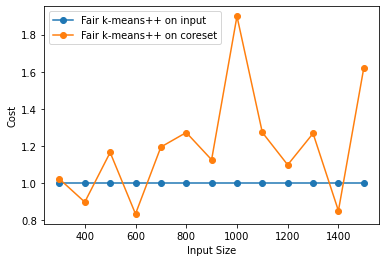

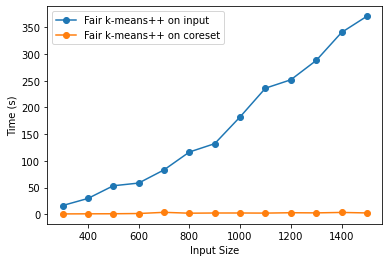

In [27]:
import time
import matplotlib.pyplot as plt

# Define 1 fixed value of k to use
k = 5

# Define the range of values for rnge to try
rnge_values = range(300, 1600 , 100)

# Initialize empty lists to store the costs and times for each value of rnge
X_costs = []
coreset_costs = []
times_X_costs = []
times_coreset_costs=[]

for rnge in rnge_values:
    # Extract the red and blue data for the current value of rnge
    bank_red = bank_data_married[:rnge].reset_index().drop('index', axis=1)
    bank_blue = bank_data_single[:rnge].reset_index().drop('index', axis=1)
    
    print("Size of Data : ", rnge )
    # Concatenate the red and blue data into a single dataset
    #bank_full_data = bank_red.append(bank_blue).reset_index().drop('index', axis=1)

    # Compute the fair k-means++ costs and times for the current value of rnge
    start_time = time.time()
    X_mapping, X_centers = fair_kmeans_pp(bank_red.iloc[:,1:].values.tolist(), bank_blue.iloc[:,1:].values.tolist(), k)
    end_time = time.time()
    X_cost = calculate_kmeans_cost(bank_red.iloc[:,1:].values.tolist() +  bank_blue.iloc[:,1:].values.tolist(), X_centers, X_mapping)
    X_costs.append(1)
    times_X_costs.append(end_time - start_time)
    print("X_cost" , X_cost )
    print("X_time"  , end_time - start_time)
    
 
    start_time = time.time()
    bank_red_coreset , bank_red_coreset_tile = run_bico(bank_red.iloc[:, 1:].to_numpy().astype(float), 100)
    bank_blue_coreset , bank_blue_coreset_tile  = run_bico(bank_blue.iloc[:, 1:].to_numpy().astype(float), 100)
    c_mapping, c_centers = fair_kmeans_pp(bank_red_coreset[:,1:].tolist(), bank_blue_coreset[:,1:].tolist(), k )
    w_coreset_cost = calculate_weighted_kmeans_cost(bank_red_coreset.tolist() + bank_blue_coreset.tolist() , c_centers, c_mapping)
    end_time = time.time()
    
    #coreset_mapping,coreset_centers = fair_assign(bank_red.iloc[:,1:].values.tolist() , bank_blue.iloc[:,1:].values.tolist() , c_centers)
    #coreset_cost = calculate_kmeans_cost(bank_red.iloc[:,1:].values.tolist() +  bank_blue.iloc[:,1:].values.tolist(), coreset_centers, coreset_mapping)
    
    coreset_costs.append(w_coreset_cost/X_cost)
    times_coreset_costs.append(end_time - start_time)
    print("coreset_cost", w_coreset_cost)
    print("coreset_time" ,  end_time - start_time )

# Plot the costs as a function of rnge
plt.plot(rnge_values, X_costs, marker='o',label='Fair k-means++ on input')
plt.plot(rnge_values, coreset_costs,  marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Input Size")
plt.ylabel("Cost")
plt.legend()
plt.show()
    
# Plot the time taken as a function of rnge
plt.plot(rnge_values, times_X_costs , marker='o',label='Fair k-means++ on input')
plt.plot(rnge_values, times_coreset_costs , marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Input Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()



In [ ]:
plt.plot(rnge_values, X_costs, marker='o',label='Fair k-means++ on input')
plt.plot(rnge_values, coreset_costs,  marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Input Size")
plt.ylabel("Cost")
plt.legend()
plt.show()
    
# Plot the time taken as a function of rnge
plt.plot(rnge_values, times_X_costs , marker='o',label='Fair k-means++ on input')
plt.plot(rnge_values, times_coreset_costs , marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Input Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


In [24]:
def calculate_weighted_kmeans_cost(coreset, centers, mapping):
    total_cost = 0
    for i in range(len(coreset)):
        assigned_center = mapping[i]
        center_coords = centers[assigned_center]
        weight = coreset[i][0]
        point_coords = coreset[i][1:]
        dist = np.linalg.norm(np.array(point_coords) - np.array(center_coords))
        total_cost += weight * dist
    return total_cost

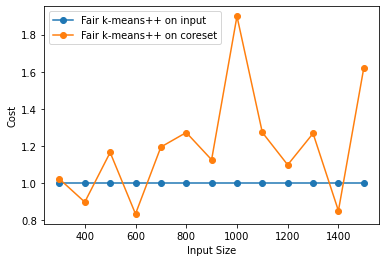

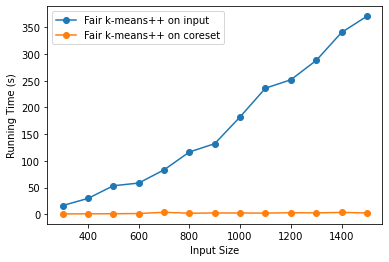

In [28]:
# Plot the costs as a function of rnge
plt.plot(rnge_values, X_costs, marker='o',label='Fair k-means++ on input')
plt.plot(rnge_values, coreset_costs,  marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Input Size")
plt.ylabel("Cost")
plt.legend()
plt.show()
    
# Plot the time taken as a function of rnge
plt.plot(rnge_values, times_X_costs , marker='o',label='Fair k-means++ on input')
plt.plot(rnge_values, times_coreset_costs , marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Input Size")
plt.ylabel("Running Time (s)")
plt.legend()
plt.show()

Value of k :  2
FD done
kmeasnpp done
cost matrix done
X_cost 78451114.15784673
X_time 20.438801765441895
FD done
kmeasnpp done
cost matrix done
coreset_cost 80233820.79532366
coreset_time 0.8592100143432617
Value of k :  3
FD done
kmeasnpp done
cost matrix done
X_cost 170764304.54854643
X_time 25.487669467926025
FD done
kmeasnpp done
cost matrix done
coreset_cost 81221348.50666146
coreset_time 1.0116991996765137
Value of k :  4
FD done
kmeasnpp done
cost matrix done
X_cost 87473069.75826357
X_time 32.413285970687866
FD done
kmeasnpp done
cost matrix done
coreset_cost 98626171.46589364
coreset_time 0.9500095844268799
Value of k :  5
FD done
kmeasnpp done
cost matrix done
X_cost 89822694.77319756
X_time 41.46131348609924
FD done
kmeasnpp done
cost matrix done
coreset_cost 89083789.1987138
coreset_time 1.2290513515472412
Value of k :  6
FD done
kmeasnpp done
cost matrix done
X_cost 74559176.02940765
X_time 48.262890577316284
FD done
kmeasnpp done
cost matrix done
coreset_cost 288606908.2

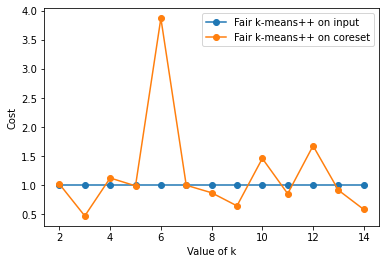

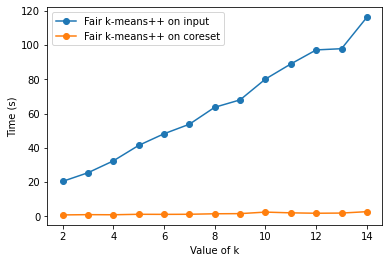

In [36]:
import time
import matplotlib.pyplot as plt

# Define the range of values for k to try
k_values = range(2, 15)

# Define a fixed value of rnge to use
rnge = 500

# Initialize empty lists to store the costs and times for each value of k
X_costs = []
coreset_costs = []
times_X_costs = []
times_coreset_costs=[]

for k in k_values:
    # Extract the red and blue data for the current value of rnge
    bank_red = bank_data_married[:rnge].reset_index().drop('index', axis=1)
    bank_blue = bank_data_single[:rnge].reset_index().drop('index', axis=1)
    
    print("Value of k : ", k )
    # Compute the fair k-means++ costs and times for the current value of k
    start_time = time.time()
    X_mapping, X_centers = fair_kmeans_pp(bank_red.iloc[:,1:].values.tolist(), bank_blue.iloc[:,1:].values.tolist(), k)
    end_time = time.time()
    X_cost = calculate_kmeans_cost(bank_red.iloc[:,1:].values.tolist() +  bank_blue.iloc[:,1:].values.tolist(), X_centers, X_mapping)
    X_costs.append(1)
    times_X_costs.append(end_time - start_time)
    print("X_cost" , X_cost )
    print("X_time"  , end_time - start_time)
    
 
    start_time = time.time()
    bank_red_coreset , bank_red_coreset_tile = run_bico(bank_red.iloc[:, 1:].to_numpy().astype(float), 100)
    bank_blue_coreset , bank_blue_coreset_tile  = run_bico(bank_blue.iloc[:, 1:].to_numpy().astype(float), 100)
    c_mapping, c_centers = fair_kmeans_pp(bank_red_coreset[:,1:].tolist(), bank_blue_coreset[:,1:].tolist(), k )
    w_coreset_cost = calculate_weighted_kmeans_cost(bank_red_coreset.tolist() + bank_blue_coreset.tolist() , c_centers, c_mapping)
    end_time = time.time()
    
    #coreset_mapping,coreset_centers = fair_assign(bank_red.iloc[:,1:].values.tolist() , bank_blue.iloc[:,1:].values.tolist() , c_centers)
    #coreset_cost = calculate_kmeans_cost(bank_red.iloc[:,1:].values.tolist() +  bank_blue.iloc[:,1:].values.tolist(), coreset_centers, coreset_mapping)
    
    coreset_costs.append(w_coreset_cost/X_cost)
    times_coreset_costs.append(end_time - start_time)
    print("coreset_cost", w_coreset_cost)
    print("coreset_time" ,  end_time - start_time )

# Plot the costs as a function of k
plt.plot(k_values, X_costs, marker='o',label='Fair k-means++ on input')
plt.plot(k_values, coreset_costs,  marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Value of k")
plt.ylabel("Cost")
plt.legend()
plt.show()
    
# Plot the time taken as a function of k
plt.plot(k_values, times_X_costs , marker='o',label='Fair k-means++ on input')
plt.plot(k_values, times_coreset_costs , marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Value of k")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


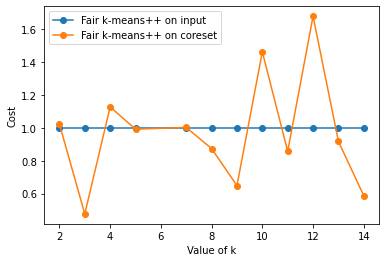

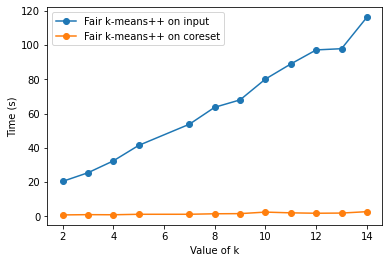

In [37]:
# Remove the cost at index 5
index_to_remove = 4
k_values = np.delete(k_values, index_to_remove)
X_costs = np.delete(X_costs, index_to_remove)
coreset_costs = np.delete(coreset_costs, index_to_remove)
times_X_costs = np.delete(times_X_costs, index_to_remove)
times_coreset_costs = np.delete(times_coreset_costs, index_to_remove)

# Plot the cost as a function of k
plt.plot(k_values, X_costs, marker='o', label='Fair k-means++ on input')
plt.plot(k_values, coreset_costs,  marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Value of k")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Plot the time taken as a function of k
plt.plot(k_values, times_X_costs , marker='o',label='Fair k-means++ on input')
plt.plot(k_values, times_coreset_costs , marker='o' , label = 'Fair k-means++ on coreset')
plt.xlabel("Value of k")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
